In [59]:
import random
import numpy as np
import sys
sys.path.append('..')
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from GridWorld_v4 import GridWorld_v4
from draw import draw  #绘图函数

In [60]:
class ReplayBuffer:
    def __init__(self,capacity):
        self.buffer=set()
    def add(self,state, action, reward, next_state, done):
        self.buffer.add((state, action, reward, next_state, done))
    def sample(self,batch_size):
        transitions=random.sample(list(self.buffer),batch_size)
        state, action, reward, next_state, done=zip(*transitions)

        # print('buffer',state)
        return np.array(state), action, reward, np.array(next_state), done
        
    def size(self):
        return len(self.buffer)

In [61]:
# 网络
class Qnet(torch.nn.Module):
    def __init__(self,state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.f1=torch.nn.Linear(state_dim,hidden_dim)
        self.f2=torch.nn.Linear(hidden_dim,action_dim)
    def forward(self,x):
        x=F.relu(self.f1(x))
        return self.f2(x)

In [67]:
class DQN(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        super(DQN, self).__init__()
        self.device=device
        self.gamma=gamma
        self.epsilon=epsilon
        self.target_update=target_update
        self.learning_rate=learning_rate
        self.action_dim=action_dim


        self.q_net=Qnet(state_dim,hidden_dim,action_dim).to(device)
        self.target_q_net=Qnet(state_dim,hidden_dim,action_dim).to(device)

        self.optimizer=torch.optim.Adam(self.q_net.parameters(),learning_rate)
        self.count=0
    # 输入一维
    def take_action(self,state):

        # 随机选择action
        if random.random()<self.epsilon:
            action=np.random.randint(self.action_dim)
        else:
            # qnet选择action
            state=torch.tensor([state],dtype=torch.float).to(self.device)
            action=self.q_net(state).argmax(dim=1).item()
        return action
    def update(self,transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)   

        # print('states',states.shape)
        pred=self.q_net(states)

        # gather输出和index shape一致
        q_values=pred.gather(dim=1,index=actions)

        # 使用target_q_net计算 target
        next_q_values=self.target_q_net(next_states).max(1)[0].view(-1,1)
        target=rewards+self.gamma*next_q_values*(1-dones)

        loss=torch.mean(F.mse_loss(target,q_values))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.count%self.target_update==0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count+=1     

In [68]:
rows = 5      #记得行数和列数这里要同步改
columns = 5
env=GridWorld_v4(forbiddenAreaScore=-10, score=10,desc = [".....",".##..","..#..",".#T#.",".#..."]) 
env.show()
trajectorySteps = 1000

⬜️⬜️⬜️⬜️⬜️
⬜️🚫🚫⬜️⬜️
⬜️⬜️🚫⬜️⬜️
⬜️🚫✅🚫⬜️
⬜️🚫⬜️⬜️⬜️


In [69]:
lr = 0.0015
num_episodes = 500
hidden_dim = 128
gamma = 0.9
# epsilon = 0.01
epsilon = 1
target_update = 10
buffer_size = 10000
minimal_size = 16
batch_size = 8
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = 2
action_dim = 5

# agent
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

Iteration:0: 100%|██████████████████████████████████████████| 50/50 [00:10<00:00,  4.91it/s, episode:=50, reward:=-102]


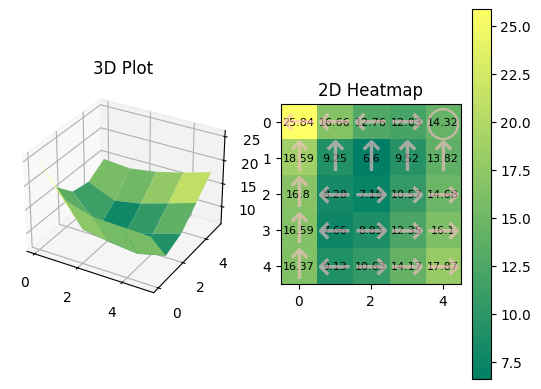

Iteration:1: 100%|█████████████████████████████████████████| 50/50 [00:11<00:00,  4.19it/s, episode:=100, reward:=-164]


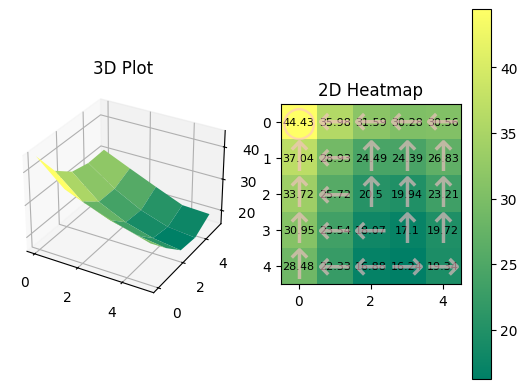

Iteration:2: 100%|█████████████████████████████████████████| 50/50 [00:09<00:00,  5.15it/s, episode:=150, reward:=-133]


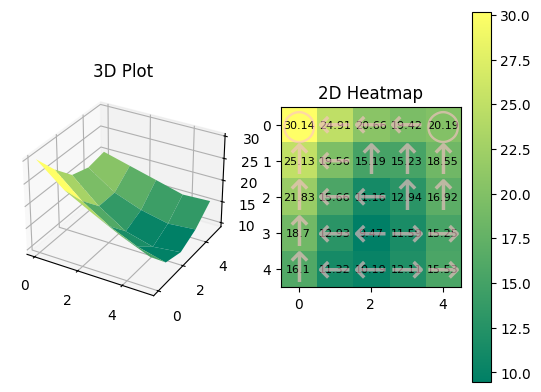

Iteration:3: 100%|█████████████████████████████████████████| 50/50 [00:06<00:00,  7.44it/s, episode:=200, reward:=-109]


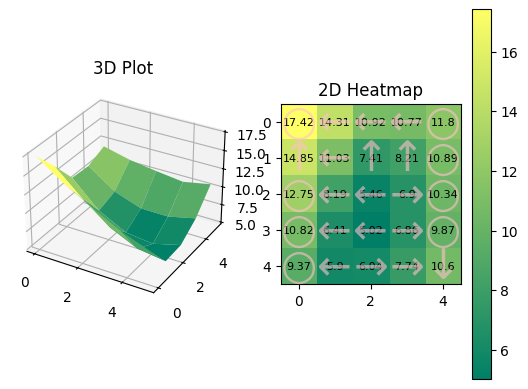

Iteration:4: 100%|████████████████████████████████████████| 50/50 [00:05<00:00,  9.54it/s, episode:=250, reward:=-94.8]


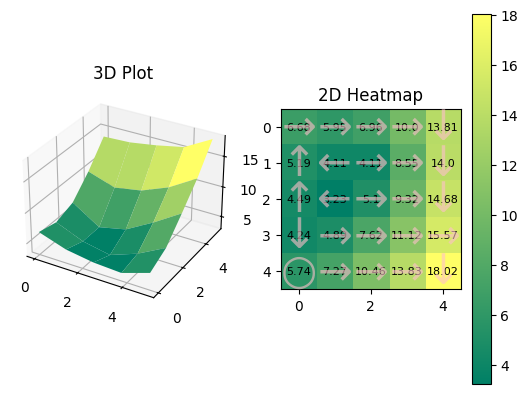

Iteration:5: 100%|█████████████████████████████████████████| 50/50 [00:06<00:00,  7.83it/s, episode:=300, reward:=-121]


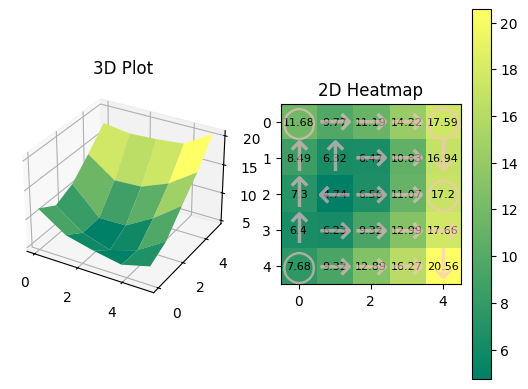

Iteration:6: 100%|█████████████████████████████████████████| 50/50 [00:06<00:00,  7.46it/s, episode:=350, reward:=-112]


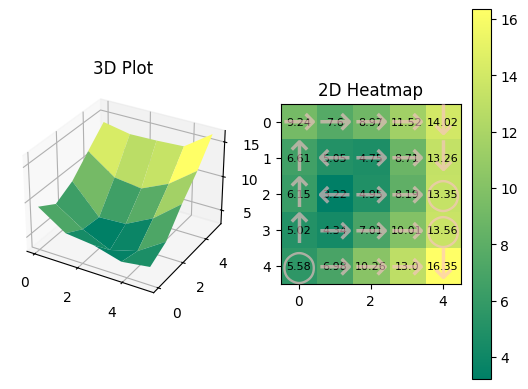

Iteration:7: 100%|██████████████████████████████████████████| 50/50 [00:06<00:00,  7.33it/s, episode:=400, reward:=-91]


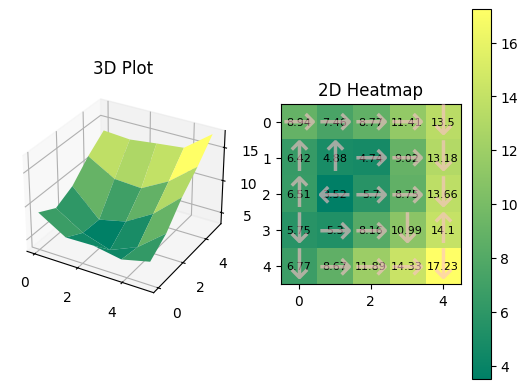

Iteration:8: 100%|████████████████████████████████████████| 50/50 [00:05<00:00,  9.79it/s, episode:=450, reward:=-97.5]


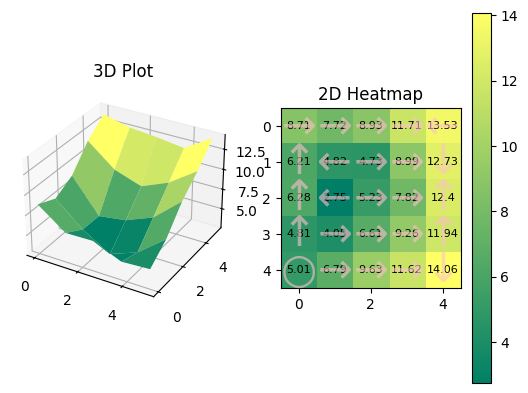

Iteration:9: 100%|████████████████████████████████████████| 50/50 [00:06<00:00,  7.79it/s, episode:=500, reward:=-98.1]


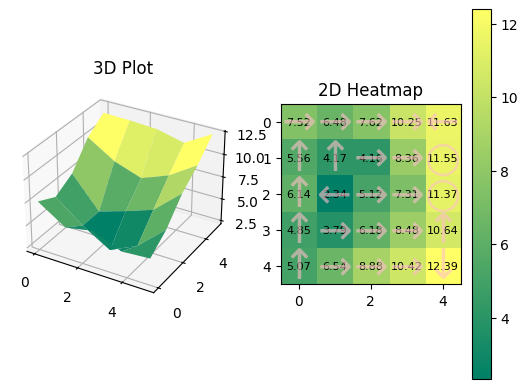

Iteration:10: 100%|███████████████████████████████████████| 50/50 [00:05<00:00,  9.07it/s, episode:=550, reward:=-61.2]


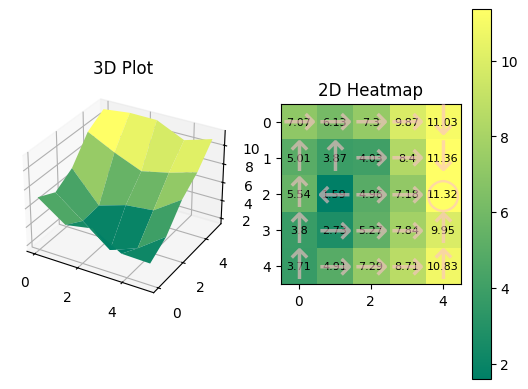

Iteration:11: 100%|███████████████████████████████████████| 50/50 [00:08<00:00,  5.89it/s, episode:=600, reward:=-99.6]


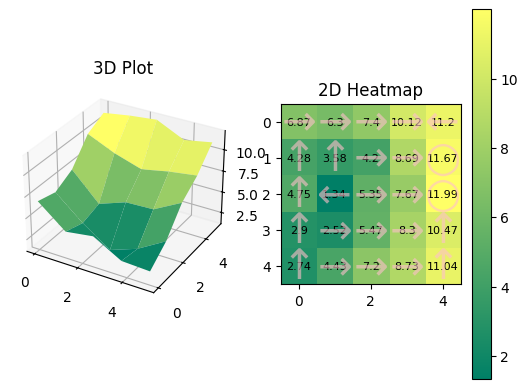

Iteration:12: 100%|███████████████████████████████████████| 50/50 [00:07<00:00,  6.49it/s, episode:=650, reward:=-57.3]


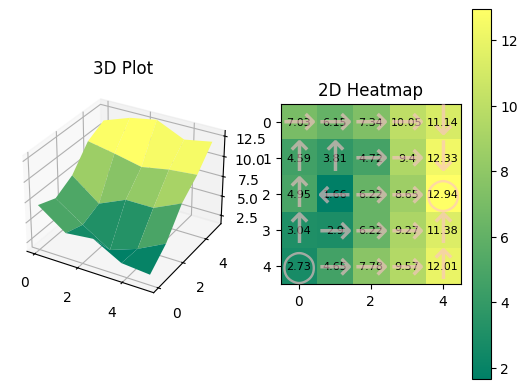

Iteration:13: 100%|████████████████████████████████████████| 50/50 [00:12<00:00,  4.08it/s, episode:=700, reward:=-201]


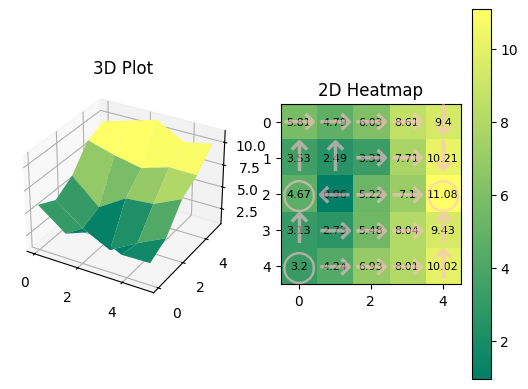

Iteration:14: 100%|███████████████████████████████████████| 50/50 [00:05<00:00,  9.80it/s, episode:=750, reward:=-36.7]


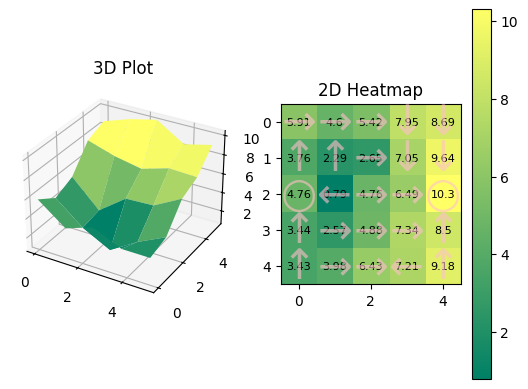

Iteration:15: 100%|███████████████████████████████████████| 50/50 [00:07<00:00,  6.57it/s, episode:=800, reward:=-95.1]


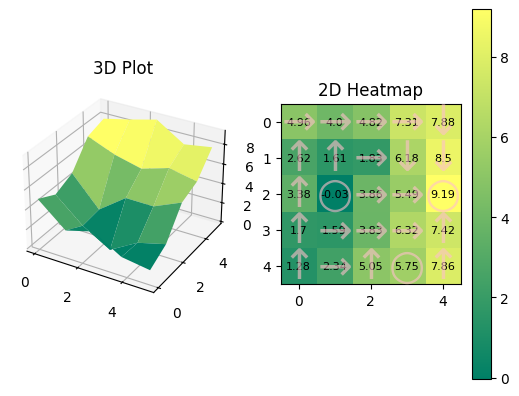

Iteration:16: 100%|████████████████████████████████████████| 50/50 [00:06<00:00,  8.13it/s, episode:=850, reward:=-136]


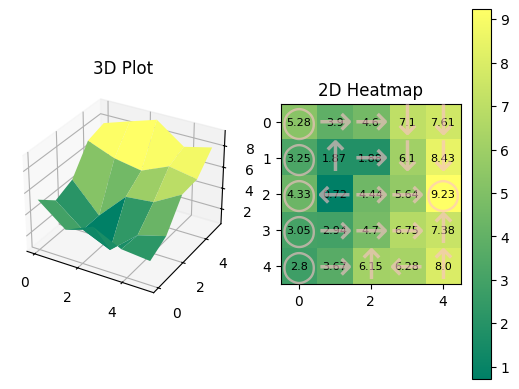

Iteration:17: 100%|████████████████████████████████████████| 50/50 [00:10<00:00,  4.98it/s, episode:=900, reward:=-100]


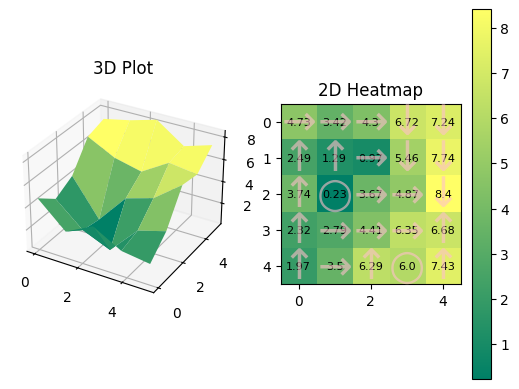

Iteration:18: 100%|███████████████████████████████████████| 50/50 [00:05<00:00,  9.29it/s, episode:=950, reward:=-87.2]


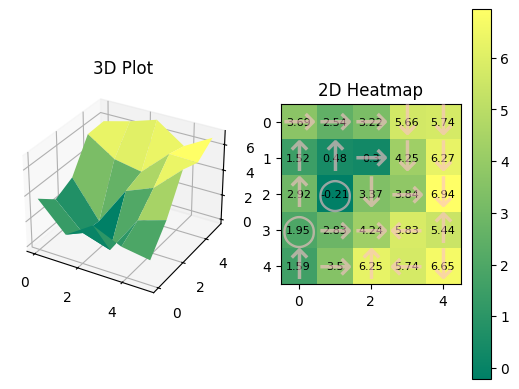

Iteration:19: 100%|██████████████████████████████████████| 50/50 [00:05<00:00,  8.39it/s, episode:=1000, reward:=-92.2]


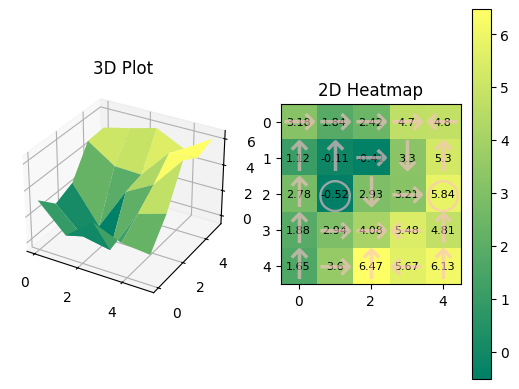

Iteration:20: 100%|██████████████████████████████████████| 50/50 [00:06<00:00,  8.20it/s, episode:=1050, reward:=-53.9]


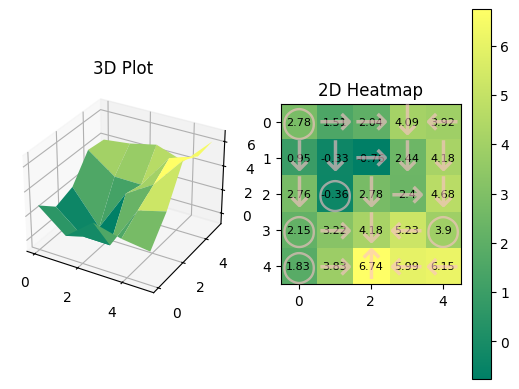

Iteration:21: 100%|██████████████████████████████████████| 50/50 [00:08<00:00,  5.84it/s, episode:=1100, reward:=-83.6]


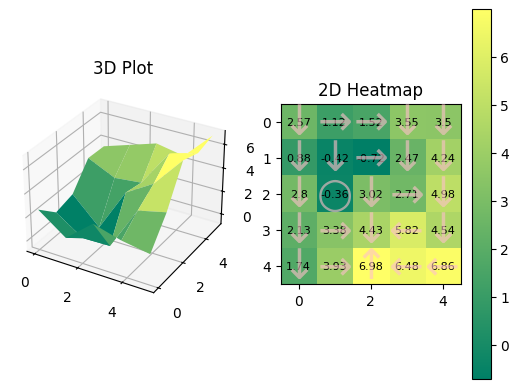

Iteration:22: 100%|██████████████████████████████████████| 50/50 [00:04<00:00, 10.26it/s, episode:=1150, reward:=-69.5]


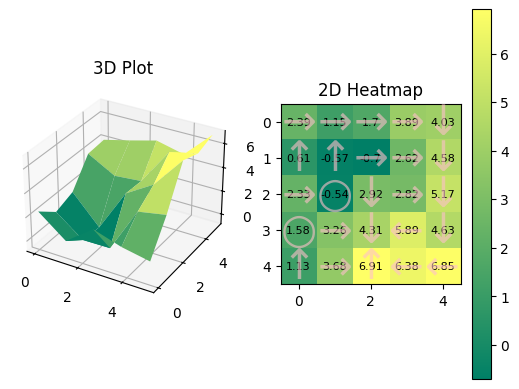

Iteration:23: 100%|██████████████████████████████████████| 50/50 [00:04<00:00, 10.43it/s, episode:=1200, reward:=-55.4]


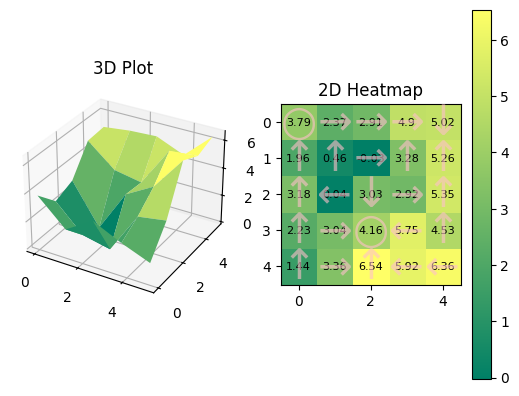

Iteration:24: 100%|██████████████████████████████████████| 50/50 [00:03<00:00, 13.97it/s, episode:=1250, reward:=-79.5]


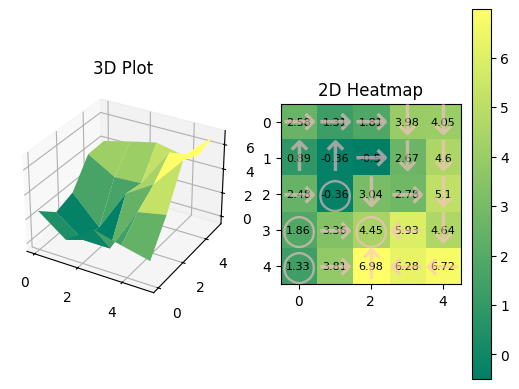

Iteration:25: 100%|██████████████████████████████████████| 50/50 [00:04<00:00, 11.48it/s, episode:=1300, reward:=-59.3]


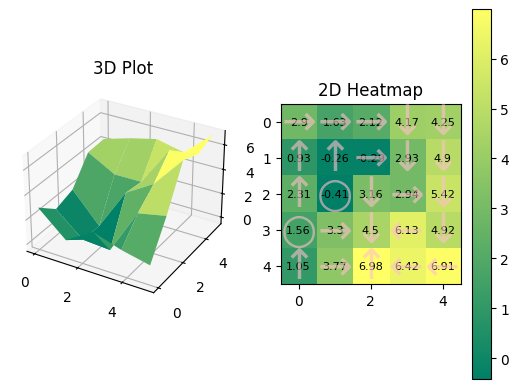

Iteration:26:   2%|█▍                                                                   | 1/50 [00:00<00:36,  1.36it/s]


KeyboardInterrupt: 

In [70]:
reward_list=[]
for i in range(100):
    with tqdm(total=int(num_episodes/10),desc='Iteration:%d'%i)as bar:
        if epsilon>0.05:
            epsilon-=0.005
        agent.epsilon=epsilon
        
        for episode in range(int(num_episodes/10)):
            state=env.reset()
            done=False
            episode_return=0
            while not done:
                action=agent.take_action((state//5,state%5))
                nextState,score,done,_=env.step(action)
                replay_buffer.add((state//5,state%5), action, score, (nextState//5,nextState%5), done)
                state=nextState
                episode_return+=score
                # 收集到一定量再训练
                if replay_buffer.size()>minimal_size:
                    # sample采样
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    # 更新网络
                    agent.update(transition_dict)
            reward_list.append(episode_return)
            
            if (episode+1)%10==0:
                bar.set_postfix({
                    'episode:':(i*(int(num_episodes/10))+episode+1),
                    'reward:':(np.mean(reward_list[-10:]))}
                )
            bar.update(1)
    # 测试网络
    state=np.array([[i,j] for i in range(5) for j in range(5)])
    state=torch.tensor(state,dtype=torch.float).to(device)
    action_value=agent.target_q_net(state).cpu().view(-1,5).detach().numpy()

    d={1:1-epsilon*(4/5),0:epsilon/5}
    greedy_policy=np.argmax(action_value,axis=1)
    policy=np.eye(5)[greedy_policy]

    epsilon_policy=np.vectorize(d.get)(policy)
    state_value=np.sum(action_value*epsilon_policy,axis=1)

    draw(state_value.reshape(5,5),greedy_policy)
    